<font color='blue'> **44e_Beta_500_1000'** </font> 
<font color='red'> **_______________________________  _______________________________** </font> 

In [1]:
import os ; from pathlib import Path ; from pprint import pformat ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env ;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
_R = Path("_R")   ; _R.mkdir(exist_ok=True); DA = Path('_R/44e_Beta_500_1000'); DA.mkdir(exist_ok=True)               ; from flopy.plot.styles import styles ; import pandas as pd 
sim_name = '44_ex-gwt-mt3dms-p08' ; import csv; REF2=Path("E:/15_REPOS/02_Beta-Me/data/Krig/Beta03")              ; from flopy.utils.postprocessing import get_water_table

In [2]:
nlay=30;nrow=1;ncol=100    ; delz=10;delc=1.0;delr=10                    ; nouter,ninner=100,300 ;hclose,rclose,relax=1e-6,1e-6,1.0;percel=1.0
top=500                    ; botm=[top-delz*k for k in range(1,nlay+1)]  ; icelltype = 1*[1]+29*[0]           ; mixelm = -1       ; idomain = 1  
trpt= 0.5; trpv=0.01      ; dmcoef = 1.34e-5/100/100*86400              ; al=0.5  ;ath1=al*trpt;atv=al*trpv   ; print('ath1 atv:' ,ath1,atv)         # ; rech = 10/100/365

ath1 atv: 0.25 0.005


In [3]:
HK = [] 
for k in range(nlay):                                                                       
    HK_ = np.empty((nrow * ncol), float)   ; f1 = open(REF2/'hk{}.csv'.format(k + 1))  ; HK_ = read1d(f1, HK_).reshape(nrow, ncol)      ; HK.append(HK_) ; k11 = HK #; print(HK)  HK[0]'''

with open(REF2/'CHD_B99.csv', mode='r') as file:  # try:# except ValueError as e:     print(f"Error converting row: {row} - {e}")                               
    CSV = csv.reader(file)                 ; data = []
    for row in CSV:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3]), int(row[4])] ; data.append(CC)  
    
with open(REF2/'CNC1.csv', mode='r') as file:                                      
    CSV = csv.reader(file)                 ; data2 = []
    for row in CSV:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3])]              ; data2.append(CC)
with open(REF2/'CNC0.csv', mode='r') as file:                                      
    CSV = csv.reader(file)                 ; data3 = []
    for row in CSV:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3])]              ; data3.append(CC)
n='n';                                     CNC = {0: data2, 1: data3}                                               ; CHD = {0: data} 

perlen = [1 * 365, 4 * 365]    ; nper = len(perlen) ; nstp = [365, 2* 365] ; tsmult = [1.0, 1.0]    ; prsity=0.35 ; sconc=0.0 ; length_units="meters";time_units="days"  ; tdis_rc = []
for i in range(nper):            tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

with open(REF2/'UNC1.csv', mode='r', newline='') as file:     CSV = csv.DictReader(file)          ; OBS_UNC = [row['col'] for row in CSV]
UNC=[('CONCENTRATION', 'LAST'),OBS_UNC,('BUDGET', 'LAST')]                                        ; print(tdis_rc)

[(365, 365, 1.0), (1460, 730, 1.0)]


In [4]:
vani =0.1  ; k33=[HK[0]*vani ,HK[1]*vani ,HK[2]*vani ,HK[3]*vani ,HK[4]*vani ,HK[5]*vani ,HK[6]*vani ,HK[7]*vani ,HK[8]*vani ,HK[9]*vani ,HK[10]*vani,HK[11]*vani,HK[12]*vani,HK[13]*vani,
                 HK[14]*vani,HK[15]*vani,HK[16]*vani,HK[17]*vani,HK[18]*vani,HK[19]*vani,HK[20]*vani,HK[21]*vani,HK[22]*vani,HK[23]*vani,HK[24]*vani,HK[25]*vani,
                 HK[26]*vani,HK[27]*vani,HK[28]*vani,HK[29]*vani] 

<font color='blue'> **MODFLOW | MT3D __________________________________________________________________________** </font>

In [5]:
def build_models(mixelm=0, silent=False):
    global sim ,gwf, gwt , npf , DB
    name = "p08"    ;gwfname="gwf-"+name ;gwtname="gwt-"+name                      ; DB = os.path.join(DA/name)      ; sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=DB)
    
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)                                 ; HPRINT= [("HEAD", "LAST"), ("BUDGET", "LAST")]
    gwf    = flopy.mf6.ModflowGwf (sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")            ; HCREC  = [("COLUMNS",10,"WIDTH",15,"DIGITS",6,"GENERAL")]
    imsgwf = flopy.mf6.ModflowIms (sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa=0.08,under_relaxation_gamma=0.05,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit=5.0e-4,inner_dvclose=hclose,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2,preconditioner_levels=8,preconditioner_drop_tolerance=0.001,filename=f"{gwfname}.ims")             ; sim.register_ims_package(imsgwf, [gwf.name])          
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwfname}.dis",)
    npf = flopy.mf6.ModflowGwfnpf (gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    sto = flopy.mf6.ModflowGwfsto (gwf, ss=0, sy=0)                                                                       ; flopy.mf6.ModflowGwfic(gwf, strt=0, filename=f"{gwfname}.ic")     
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(CHD),   stress_period_data=CHD,  save_flows=False,auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
    #rcha = flopy.mf6.ModflowGwfrcha (gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{gwfname}.rch") 
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",headprintrecord=HCREC,saverecord=HPRINT,printrecord=HPRINT)
    
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")         ; gwt.name_file.save_flows = True  ; FI = f"{gwtname}.ic"
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa =0.08  ,under_relaxation_gamma =0.05 ,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit  =5.0e-4,inner_dvclose=hclose   ,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2  ,preconditioner_levels=8,preconditioner_drop_tolerance=0.001  ,filename=f"{gwtname}.ims")             ;sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwtname}.dis") ;flopy.mf6.ModflowGwtic(gwt,strt=sconc,filename=FI)
    if   mixelm >= 0:   scheme = "UPSTREAM"
    elif mixelm == -1:  scheme = "TVD"
    else:               raise Exception()
    flopy.mf6.ModflowGwtadv (gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:                                                                                flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,filename=f"{gwtname}.dsp")
    flopy.mf6.ModflowGwtmst (gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    flopy.mf6.ModflowGwtssm (gwt, sources=[("CHD-1", "AUX", "CONCENTRATION")], filename=f"{gwtname}.ssm")            ; PRINT = [("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
    flopy.mf6.ModflowGwtoc  (gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",concentrationprintrecord=HCREC,saverecord=UNC,printrecord=PRINT)
    cnc = flopy.mf6.ModflowGwtcnc (gwt,print_flows=True,stress_period_data=CNC,pname="CNC-1",filename=f"{gwtname}.cnc")   
    flopy.mf6.ModflowGwfgwt (sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")               ; return sim

def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent, report=True)                              ; assert success, pformat(buff)
def scenario(idx, silent=True): 
    sim = build_models(mixelm=mixelm)
    if write:       write_models(sim, silent=True)
    if run:         run_models(sim, silent=silent)              
scenario(0, silent=True)    # 26'' 55''

<font color='orange'> **RES________________________________________________** </font>

In [6]:
DC = list(os.listdir(DA)) # ;print(list(os.listdir(DA)))
F3 = os.path.join(DA/DC[0]/'gwf-p08.hds')      ;hdobj=flopy.utils.HeadFile(F3)                   ; HH=hdobj.get_data()                  ; TI = hdobj.get_times()
sim.set_sim_path(os.path.join(DA/DC[0]))       ; gwt = sim.get_model(list(sim.model_names)[1])   ; ucnobj = gwt.output.concentration()  ; CC = ucnobj.get_alldata() 
LEV=np.arange(HH.min(),0,-HH.min()/10)         ; wt=get_water_table(HH)                          ; K=gwf.npf.k.array                    ; RR={'Row':0};MV=[K[0,0,0]] # CC levels=CL
SELECT=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]                                       #; pd.DataFrame(CC.reshape(-1)).describe().transpose() # CC

In [7]:
SS= 0.2                             ; print('CCmin:',round(CC.min(),1),'___________________________ new_LC2: ',round(np.quantile(CC, SS),6))
LH=np.arange(300, 501, 25)  ;LC1=[.1,2.5,9.5]     ; LC2 = np.round(np.arange(np.quantile(CC, SS)  ,CC.max()*.95   ,CC.max()/5  ),6).tolist()   ;print('__LH:','__LC1:',LC1,'___ LC2:',LC2)

CCmin: -1e+30 ___________________________ new_LC2:  0.0
__LH: __LC1: [0.1, 2.5, 9.5] ___ LC2: [0.0, 2.0, 4.0, 6.0, 8.0]


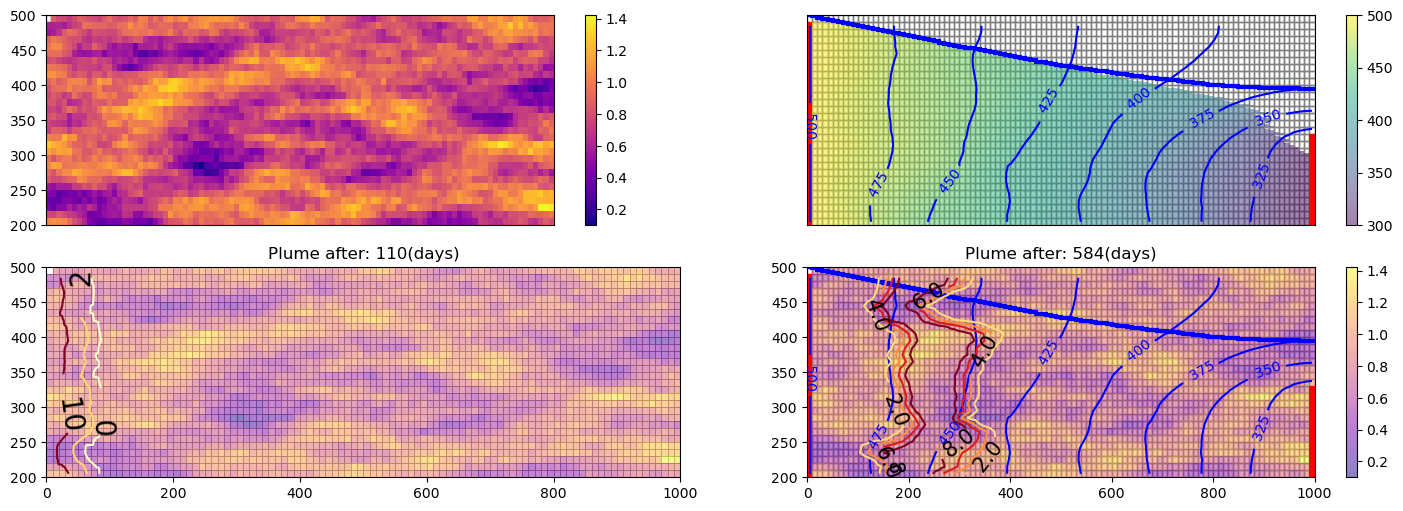

In [8]:
fig = plt.figure(figsize=(18, 6))  
ax = fig.add_subplot(221) ;ma=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; ma.plot_grid(lw=1) ; bx=ma.plot_array(K, masked_values=MV,cmap='plasma') ; fig.colorbar(bx);ax.xaxis.set_visible(False) 
ax = fig.add_subplot(222) ;mb=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; mb.plot_grid(lw=1) ; cx=mb.plot_array(HH,head=HH,alpha=0.5)    ; fig.colorbar(cx);ax.xaxis.set_visible(False);ax.yaxis.set_visible(False)  
mb.plot_bc("CHD",color ='red') ; mb.plot_surface(wt, color="b", lw=3)                             ; dx=mb.contour_array(HH, colors='b',levels=LH) ;plt.clabel(dx, fmt=r"%4.0f", fontsize=10) 

A=2; ax = fig.add_subplot(223) ;ma=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; ma.plot_grid(lw=0.5)    ; cx=ma.plot_array(K, masked_values=MV, alpha=0.5,cmap='plasma')
mb.plot_bc("CHD",color ='red') ;ex=ma.contour_array(CC[SELECT[A]],cmap='YlOrRd',levels=LC1);plt.clabel(ex,fmt=r"%4.0f",colors='black',fontsize=20) ; plt.title("Plume after: "+str(UNC[1][A+2]) + "(days)")

A=15;ax = fig.add_subplot(224) ;mb=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; mb.plot_grid(lw=1)      ; bx=mb.plot_array(K, masked_values=MV, alpha=0.5,cmap='plasma'); fig.colorbar(bx)
mb.plot_bc("CHD",color ='red') ;mb.plot_surface(wt, color="b", lw=3)                                       ; dx=mb.contour_array(HH, colors='b',levels=LH) ;plt.clabel(dx, fmt=r"%4.0f") 
ex = mb.contour_array(CC[SELECT[A]],cmap='YlOrRd',levels=LC2);plt.clabel(ex, fmt=r"%4.1f", colors='black', fontsize=15)                 ; plt.title("Plume after: "+str(UNC[1][A+2]) + "(days)")
plt.show()

In [9]:
DB = Path(DB)  
pd.DataFrame(tdis_rc).to_csv(DB/"01_tdis_rc.csv")
with open(DB/'02_temp_08.csv', "w") as file:
    for item in TI: file.write("%s\n" % item)
with open(DB/'03_UNC.csv', "w") as file:
    for item in UNC[1]: file.write("%s\n" % item)

In [10]:
#KA = 5e-4 / 100.0 * 86400  ;  KB = 1e-2 / 100.0 * 86400  ; print(KA, KB)
print(UNC[1][11])

365


In [11]:
UNC[1][5]

'146'